Convierte las MRI a escala de grises, redimensiona y normaliza.

Extrae HOG + LBP + estadísticas de intensidad (media, desvío, asimetría, curtosis).

Entrena y compara SVM-RBF, Random Forest y Regresión Logística vía GridSearchCV con validación estratificada.

Reporta accuracy, F1 macro, matriz de confusión y ROC OvR.

Reentrena el mejor en todo Training/ y evalúa en Testing/.

Guarda el modelo y una función predict_image(...).

Incluye MLflow opcional (si está instalado, registra parámetros y métricas; si no, corre igual).

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# ===== 0) Setup (Colab) =====
!pip install -q --upgrade tensorflow==2.15.*  # (Colab ya trae TF; esto asegura versión reciente)

import os, numpy as np, tensorflow as tf
from pathlib import Path

print(tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

# Mezcla de precisión (saca jugo a GPU)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.* (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.*
2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
!nvidia-smi


Tue Sep  2 03:19:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
# ===== 1) Paths y parámetros =====
BASE_DIR = Path("/content/drive/MyDrive/archive")
TRAIN_DIR = BASE_DIR / "Training"
TEST_DIR  = BASE_DIR / "Testing"

IMG_SIZE   = (224, 224)   # usar 192/160 para mayor rapidez
BATCH_SIZE = 32
SEED       = 42
CLASSES    = ['glioma','meningioma','notumor','pituitary']  # opcional, se detectan del dir


In [10]:
# ===== 2) Datasets (tf.data) =====
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='int',
    class_names=CLASSES, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=True, seed=SEED, validation_split=0.2, subset='training'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='int',
    class_names=CLASSES, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=True, seed=SEED, validation_split=0.2, subset='validation'
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='int',
    class_names=CLASSES, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=False
)

# Performance: cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1321 files belonging to 4 classes.


In [11]:
# ===== 3) Data Augmentation & Preprocessing =====
from tensorflow import keras
from tensorflow.keras import layers

data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_aug")

In [12]:
# ===== 4) Modelo (Transfer Learning) =====
# Opción: EfficientNetB0 (rápida);  B3/B4 mas tardado
base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,)
)
base.trainable = False  # fase 1: congelado

inputs = layers.Input(shape=IMG_SIZE+(3,))
x = data_aug(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(CLASSES), activation="softmax", dtype="float32")(x)  # salida float32
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
# ===== 5) Callbacks =====
ckpt_path = "best_efficientnet_b0.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_accuracy", mode="max"),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6, monitor="val_loss")
]


In [14]:
# ===== 6) Entrenamiento Fase 1 =====
history_1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=10, callbacks=callbacks
)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1522s 10s/step - accuracy: 0.5967 - loss: 0.9447 - val_accuracy: 0.7653 - val_loss: 0.5605 - learning_rate: 0.0010
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.8219 - loss: 0.4956 - val_accuracy: 0.7872 - val_loss: 0.5059 - learning_rate: 0.0010
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.8350 - loss: 0.4345 - val_accuracy: 0.7977 - val_loss: 0.4860 - learning_rate: 0.0010
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.8470 - loss: 0.3941 - val_accuracy: 0.8082 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.8626 - loss: 0.3724 - val_accuracy: 0.8170 - val_loss: 0.4457 - learning_rate: 0.0010
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.8702 - loss: 0.3461 - val_accuracy: 0.8109 - val_loss: 0.4470 - learning_rate: 0.0010
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.8733 - 

In [15]:
# ===== 7) Fine-tuning  =====
# Descongela algunas capas superiores (p. ej., último 20%)
for layer in base.layers[int(0.8*len(base.layers)):]:
    layer.trainable = True
# Compila con LR más baja
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=10, callbacks=callbacks
)

# Carga mejor modelo guardado
best_model = keras.models.load_model(ckpt_path)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 189ms/step - accuracy: 0.7642 - loss: 0.6365 - val_accuracy: 0.8494 - val_loss: 0.4021 - learning_rate: 1.0000e-05
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.8315 - loss: 0.4461 - val_accuracy: 0.8634 - val_loss: 0.3875 - learning_rate: 1.0000e-05
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.8551 - loss: 0.3772 - val_accuracy: 0.8616 - val_loss: 0.3692 - learning_rate: 1.0000e-05
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.8785 - loss: 0.3463 - val_accuracy: 0.8739 - val_loss: 0.3456 - learning_rate: 1.0000e-05
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.8875 - loss: 0.3166 - val_accuracy: 0.8818 - val_loss: 0.3263 - learning_rate: 1.0000e-05
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.8894 - loss: 0.3008 - val_accuracy: 0.8818 - val_loss: 0.3159 - learning_rate: 1.0000e-05
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 10

In [17]:
# ===== 8) Evaluación en TEST =====
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
print(f"[TEST] Accuracy = {test_acc:.4f}")


[TEST] Accuracy = 0.8910


              precision    recall  f1-score   support

      glioma       0.91      0.83      0.87       300
  meningioma       0.84      0.75      0.79       306
     notumor       0.96      0.97      0.96       405
   pituitary       0.84      0.98      0.91       310

    accuracy                           0.89      1321
   macro avg       0.89      0.88      0.88      1321
weighted avg       0.89      0.89      0.89      1321



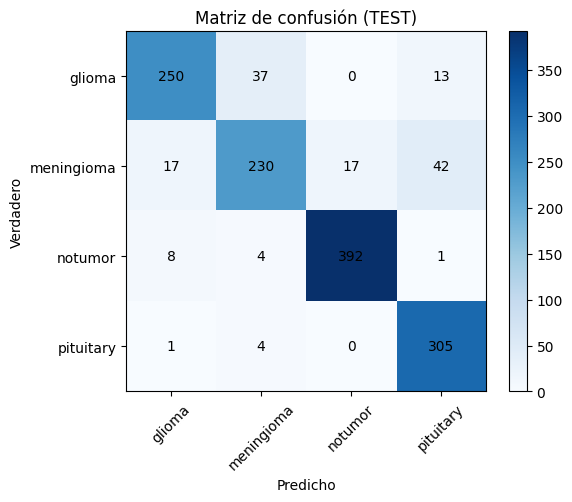

In [18]:
# ===== 9) Métricas extra: matriz de confusión / reporte =====
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_true = np.concatenate([y.numpy() for _, y in test_ds.unbatch().batch(1024)])
y_prob = best_model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de confusión (TEST)")
plt.colorbar()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45)
plt.yticks(tick_marks, CLASSES)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicho"); plt.ylabel("Verdadero"); plt.tight_layout(); plt.show()

In [19]:
# ===== 10) Guardar para inferencia =====
best_model.save("brain_tumor_efficientnet_b0.keras")

# Ejemplo de inferencia en 1 imagen (ruta absoluta o de Drive)
def predict_image_tf(path_to_img: str):
    import tensorflow as tf
    from tensorflow.keras.preprocessing import image as kimage
    img = kimage.load_img(path_to_img, target_size=IMG_SIZE)
    arr = kimage.img_to_array(img)[None, ...]  # (1,H,W,3)
    arr = tf.keras.applications.efficientnet.preprocess_input(arr)
    prob = best_model.predict(arr, verbose=0)[0]
    idx = int(np.argmax(prob))
    return CLASSES[idx], float(prob[idx]), {CLASSES[i]: float(p) for i, p in enumerate(prob)}

# pred, conf, probs = predict_image_tf("/content/drive/MyDrive/…/una_imagen.jpg")
# print(pred, conf); print(probs)
